In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
from scipy.stats import zscore

from sklearn.model_selection import GridSearchCV,KFold

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
import numpy as np

from sklearn.model_selection import KFold

In [4]:
%matplotlib inline

In [5]:
labels = pd.read_csv("../07_Feature_Preprocessing/label_data_complete.txt",
                     sep="\t", decimal=',').set_index("Subject_ID")

# Read all feature data

- Behavioural
    - over all data
    - over sub-blocks of 12
    - dimensionality reduction
- evoked (ERP)
    - mean amplitude 100 ms
        - raw values
        - latent factors
    - peak amplitude
        - global max min
        - local max min
    - area
        - abs pos neg
    - latency
        - global max min
        - local max min
        - midpoint max min
        - onset max min
    - autcorrelation
    - interconnectivity (only take lower matrix!)
- epochs
    - mean maximum power
    - connectivity
        - WPLI raw (only take lower matrix!) (wpli.csv)
        - latent factor (wpli_latFact.csv)

In [420]:
allfeaturesets = dict()

In [421]:
feats_RT = pd.read_csv("../06_Feature Extraction/finalDF_56_4_SAME_SAME_SAME_.txt", sep="\t").set_index("Subject_ID")

In [422]:
allfeaturesets["RT"] = feats_RT
allfeaturesets["RT_allData"] = feats_RT[list(feats_RT.columns[:14]) + list(feats_RT.columns[-5:])]
allfeaturesets["RT_subblocks12"] = feats_RT[feats_RT.columns[14:26]]
allfeaturesets["RT_dimred"] = feats_RT[feats_RT.columns[26:-5]]



In [423]:
feats_EV = pd.read_csv("../10_EEG_Features_evoked/allFeatures_evoked.csv", sep="\t",index_col=0)

In [424]:
allfeaturesets["EV"] = feats_EV
allfeaturesets["EV_meanamp100ms_raw"] = feats_EV.filter(like="evoked_Amplitude_Mean",axis=1)
allfeaturesets["EV_meanamp100ms_LF"] = pd.read_csv("../10_EEG_Features_evoked/MeanAmplitude100ms_LatenFactors.csv", sep="\t",index_col=0)
allfeaturesets["EV_Amplitude_PeakGlobal"] = feats_EV.filter(like="Amplitude_PeakGlobal",axis=1)
allfeaturesets["EV_Amplitude_PeakLocal"] = feats_EV.filter(like="Amplitude_PeakLocal",axis=1)
allfeaturesets["EV_Area"] = feats_EV.filter(like="Area_",axis=1)
allfeaturesets["EV_Latency_PeakGlobal"] = feats_EV.filter(like="Latency_PeakGlobal",axis=1)
allfeaturesets["EV_Latency_PeakLocal"] = feats_EV.filter(like="Latency_PeakLocal",axis=1)
allfeaturesets["EV_Latency_Midpoint"] = feats_EV.filter(like="Latency_Midpoint",axis=1)
allfeaturesets["EV_Latency_Onset"] = feats_EV.filter(like="Latency_Onset",axis=1)
allfeaturesets["EV_Autocorrelation"] = feats_EV.filter(like="Autocorrel_Lag",axis=1)


In [425]:
feats_EV_intercorr = feats_EV.filter(like="evoked_Intercorrel",axis=1)
feats_EV_intercorr = feats_EV_intercorr.transpose()
feats_EV_intercorr["c1c2"] = feats_EV_intercorr.index.str.split("_").str[2]
feats_EV_intercorr["t100ms"] = feats_EV_intercorr.index.str.split("_").str[3]
feats_EV_intercorr = feats_EV_intercorr.sort_values(["t100ms","c1c2"])
feats_EV_intercorr =feats_EV_intercorr.drop(["t100ms","c1c2"],axis=1)
rel_chan_ind = []
x,y = np.triu_indices(28,+1)
for t in range(8):
    rel_chan_ind += list((y+x*28) + t*784 )    
feats_EV_intercorr = feats_EV_intercorr.iloc[rel_chan_ind,:].transpose()
allfeaturesets["EV_Intercorr"] = feats_EV_intercorr

In [426]:
allfeaturesets["EP_MeanMaxPower"] = pd.read_csv("../11_EEG_Features_epochs/featsEpochs_MeanMaxPower.csv",sep="\t",index_col=0)

allfeaturesets["EP_wpli_raw"]  = pd.read_csv("../11_EEG_Features_epochs/wpli.csv",sep="\t",index_col=0) # remove lower triangle matrix
x,y = np.tril_indices(28,-1)
allfeaturesets["EP_wpli_raw"] = allfeaturesets["EP_wpli_raw"].iloc[:, (y+x*28)]

allfeaturesets["EP_wpli_LF"] = pd.read_csv("../11_EEG_Features_epochs/wpli_latFact.csv",sep="\t",index_col=0) # remove lower triangle matrix


In [427]:
allfeaturesets.keys()

dict_keys(['RT', 'RT_allData', 'RT_subblocks12', 'RT_dimred', 'EV', 'EV_meanamp100ms_raw', 'EV_meanamp100ms_LF', 'EV_Amplitude_PeakGlobal', 'EV_Amplitude_PeakLocal', 'EV_Area', 'EV_Latency_PeakGlobal', 'EV_Latency_PeakLocal', 'EV_Latency_Midpoint', 'EV_Latency_Onset', 'EV_Autocorrelation', 'EV_Intercorr', 'EP_MeanMaxPower', 'EP_wpli_raw', 'EP_wpli_LF'])

In [522]:
allfeaturesets["EP"] = allfeaturesets["EP_MeanMaxPower"].join(
    allfeaturesets["EP_wpli_raw"],how="inner").join(
    allfeaturesets["EP_wpli_LF"] )

In [538]:
allfeaturesets["all"] = getJoinedDF(allfeaturesets["EV"],getJoinedDF(allfeaturesets["RT"],allfeaturesets["EP"]) )

# ML Pipeline

In [257]:
def getJoinedDF(feats, labels):
    feats.index = [ x[:-1] if x.endswith("1") else x for x in feats.index]
    jdf =  feats.join(labels,how="inner")
    return jdf

In [258]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [431]:
def getScoresTesting(name, feats,labels):
    jDF = getJoinedDF(feats, labels)
    f_cols = feats.columns
    X = jDF[f_cols].apply(zscore)
    X=X.dropna(axis=1)
    best_scores=[]
    hyperparams = { "alpha":[.01,.1,1.0,10,100,1000,],
                 "l1_ratio": [0,.2,.4,.6,.8,1.0] }
    for targetcol in ["ImplizitesLernen_kont","ExplizitesLernen_kont"]:
        y = jDF[targetcol]
        en = ElasticNet(random_state = 23,selection ="random",)
        gs = GridSearchCV(en, hyperparams, scoring = "r2", n_jobs=-1,cv = KFold(4,True,23), verbose=0
                 ).fit(X,y)        
        best_scores+=[[name,targetcol,gs.best_score_]]
    return best_scores
        

In [435]:
bs = []
for name, feats in allfeaturesets.items():
    print(name)
    bs += getScoresTesting(name,feats, labels)

RT


I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RT_allData


I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RT_subblocks12


I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RT_dimred


I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


EV


I:\Miniconda\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


EV_meanamp100ms_raw
EV_meanamp100ms_LF


I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


EV_Amplitude_PeakGlobal
EV_Amplitude_PeakLocal
EV_Area
EV_Latency_PeakGlobal


I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


EV_Latency_PeakLocal


I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


EV_Latency_Midpoint
EV_Latency_Onset


I:\Miniconda\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


EV_Autocorrelation
EV_Intercorr


I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


EP_MeanMaxPower


I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


EP_wpli_raw
EP_wpli_LF


In [523]:
bs += getScoresTesting("EP",allfeaturesets["EP"], labels)

I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [539]:
bs += getScoresTesting("all",allfeaturesets["all"], labels)

I:\Miniconda\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
I:\Miniconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [540]:
resdf = pd.DataFrame(bs,columns=["feats","target","val"])

In [541]:
resdf.pivot_table("val","feats","target")

target                   ExplizitesLernen_kont  ImplizitesLernen_kont
feats                                                                
EP                                   -0.038036              -0.148505
EP_MeanMaxPower                      -0.038036              -0.135370
EP_wpli_LF                           -0.038036              -0.166948
EP_wpli_raw                          -0.038036              -0.166948
EV                                    0.130942              -0.117833
EV_Amplitude_PeakGlobal               0.058011              -0.151628
EV_Amplitude_PeakLocal                0.081307              -0.166948
EV_Area                               0.017868              -0.166948
EV_Autocorrelation                    0.075148              -0.152599
EV_Intercorr                         -0.020548              -0.096927
EV_Latency_Midpoint                  -0.027558              -0.166948
EV_Latency_Onset                      0.016477              -0.166948
EV_Latency_PeakGlobal                 0.026355              -0.166879
EV_Latency_PeakLocal                 -0.007173              -0.166948
EV_meanamp100ms_LF                   -0.020035              -0.166584
EV_meanamp100ms_raw                   0.058887              -0.166948
RT                                   -0.024006               0.058315
RT_allData                           -0.050077               0.019747
RT_dimred                            -0.016428               0.040095
RT_subblocks12                       -0.064842               0.066024
all                                   0.132629               0.002273

In [472]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

In [511]:
def getScoresTestingClassification(name, feats,labels):
    jDF = getJoinedDF(feats, labels)    
    f_cols = feats.columns
    X = jDF[f_cols].apply(zscore)
    X=X.dropna(axis=1)
    print(X.shape)
    best_scores=[]
    hyperparams = { "C":[.01,.1,1.0,10,100,1000,],
                  }
    for targetcol in ["ImplizitesLernen_dich","ExplizitesLernen_dich"]:
        y_ = jDF[targetcol]
        svc = LinearSVC(penalty ="l1",dual=False,random_state=23,class_weight ="balanced")
        gs = GridSearchCV(svc, hyperparams, scoring="balanced_accuracy",
                          n_jobs=-1,cv = KFold(4,True,23), verbose=0
                 ).fit(X,y_)        
        best_scores+=[[name,targetcol,gs.best_score_]]
    return best_scores
        

In [526]:
bs_clf_orig += getScoresTestingClassification("EP",allfeaturesets["EP"], labels)

(94, 1168)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [542]:
bs_clf_orig += getScoresTestingClassification("all",allfeaturesets["all"], labels)

I:\Miniconda\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(93, 15562)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [512]:
bs_clf_orig = []
for name, feats in allfeaturesets.items():
    print(name)
    bs_clf_orig += getScoresTestingClassification(name,feats, labels)

RT
(96, 84)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RT_allData
(96, 19)
RT_subblocks12
(96, 12)
RT_dimred
(96, 53)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV


I:\Miniconda\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(94, 14310)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_meanamp100ms_raw
(94, 224)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_meanamp100ms_LF
(94, 6)
EV_Amplitude_PeakGlobal
(94, 448)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_Amplitude_PeakLocal
(94, 448)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_Area
(94, 672)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_Latency_PeakGlobal
(94, 448)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_Latency_PeakLocal
(94, 448)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_Latency_Midpoint
(94, 448)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
I:\Miniconda\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


EV_Latency_Onset
(94, 423)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_Autocorrelation
(94, 4480)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_Intercorr
(94, 3024)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EP_MeanMaxPower
(94, 784)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EP_wpli_raw
(94, 378)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EP_wpli_LF
(94, 6)


In [543]:
resdf_clf_orig = pd.DataFrame(bs_clf_orig,columns=["feats","target","val"])

In [545]:
resdf_clf_orig.pivot_table("val","feats","target")

target                   ExplizitesLernen_dich  ImplizitesLernen_dich
feats                                                                
EP                                    0.500000               0.604720
EP_MeanMaxPower                       0.564710               0.636128
EP_wpli_LF                            0.537580               0.522501
EP_wpli_raw                           0.500000               0.535337
EV                                    0.562957               0.554638
EV_Amplitude_PeakGlobal               0.500000               0.548876
EV_Amplitude_PeakLocal                0.500000               0.558905
EV_Area                               0.612985               0.617964
EV_Autocorrelation                    0.580828               0.561715
EV_Intercorr                          0.560962               0.517370
EV_Latency_Midpoint                   0.500353               0.603938
EV_Latency_Onset                      0.594814               0.500000
EV_Latency_PeakGlobal                 0.525962               0.568689
EV_Latency_PeakLocal                  0.547784               0.500000
EV_meanamp100ms_LF                    0.581716               0.500000
EV_meanamp100ms_raw                   0.542804               0.500000
RT                                    0.561806               0.519841
RT_allData                            0.531076               0.567361
RT_dimred                             0.533854               0.526488
RT_subblocks12                        0.504340               0.551190
all                                   0.619591               0.558569

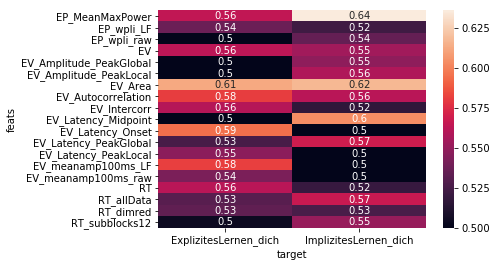

In [514]:
sns.heatmap(resdf_clf_orig.pivot_table("val","feats","target"),annot=True)

In [490]:
labels.groupby(["ImplizitesLernen_dich"]).size()

ImplizitesLernen_dich
0    19
1    78
dtype: int64

In [491]:
labels.groupby(["ExplizitesLernen_dich"]).size()

ExplizitesLernen_dich
0    38
1    59
dtype: int64

In [497]:
labels["ExplizitesLernen_Md"] = pd.qcut(labels.ExplizitesLernen_kont,2,labels=False)

In [498]:
labels["ImplizitesLernen_Md"] = 1-pd.qcut(labels.ImplizitesLernen_kont,2,labels=False)

In [509]:
def getScoresTestingClassificationMd(name, feats,labels):
    jDF = getJoinedDF(feats, labels)    
    f_cols = feats.columns
    X = jDF[f_cols].apply(zscore)
    X=X.dropna(axis=1)
    print(X.shape)
    best_scores=[]
    hyperparams = { "C":[.01,.1,1.0,10,100,1000,],
                  }
    for targetcol in ["ImplizitesLernen_Md","ExplizitesLernen_Md"]:
        y_ = jDF[targetcol]
        svc = LinearSVC(penalty ="l1",dual=False,class_weight ="balanced",random_state=23,max_iter =10000)
        gs = GridSearchCV(svc, hyperparams, scoring="balanced_accuracy",
                          n_jobs=-1,cv = KFold(4,True,23), verbose=0
                 ).fit(X,y_)        
        best_scores+=[[name,targetcol,gs.best_score_]]
    return best_scores
        

In [551]:
bs_clf = []

In [530]:
bs_clf += getScoresTestingClassificationMd("EP",allfeaturesets["EP"], labels)

(94, 1168)


In [552]:
bs_clf += getScoresTestingClassificationMd("all",allfeaturesets["all"], labels)

I:\Miniconda\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(93, 15562)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [547]:
bs_clf = []
for name, feats in allfeaturesets.items():
    print(name)
    bs_clf += getScoresTestingClassificationMd(name,feats, labels)

RT
(96, 84)
RT_allData
(96, 19)
RT_subblocks12
(96, 12)
RT_dimred
(96, 53)
EV


I:\Miniconda\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(94, 14310)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_meanamp100ms_raw
(94, 224)
EV_meanamp100ms_LF
(94, 6)
EV_Amplitude_PeakGlobal
(94, 448)
EV_Amplitude_PeakLocal
(94, 448)
EV_Area
(94, 672)
EV_Latency_PeakGlobal
(94, 448)
EV_Latency_PeakLocal
(94, 448)
EV_Latency_Midpoint
(94, 448)
EV_Latency_Onset
(94, 423)


I:\Miniconda\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


EV_Autocorrelation
(94, 4480)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EV_Intercorr
(94, 3024)


I:\Miniconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


EP_MeanMaxPower
(94, 784)


KeyboardInterrupt: 